# Massachusetts ER Wait Time Analysis

## 02 — Analysis & Visualizations

This notebook loads `data/processed/df_clean.csv` (created by **01_data_cleaning.ipynb**) and generates the key figures used in the write-up / presentation.

## Setup/Imports

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl")

In [3]:
# Load cleaned data produced by 01_data_cleaning.ipynb
import os
os.makedirs("figures", exist_ok=True)

df_clean = pd.read_csv("data/processed/df_clean.csv")
df_loc = pd.read_csv('/Users/chrisbice/Desktop/Data Projects/ER Wait-Time Analysis/ma_hospital_locations_complete.csv')

df_clean.head()

,month,emergency_department,visits,pct_monthly_visits,average_los_hours,hospital_system,city,latitude,longitude,region,correlation
0,2018-10-01,Anna Jaques Hospital,1629,0.0080,2.899785,Beth Israel Lahey Health,Newburyport,42.812000,-70.871700,North Shore,-0.275977
1,2018-10-01,Athol Memorial Hospital,854,0.0042,3.469106,Heywood Healthcare,Athol,42.595300,-72.226600,Central MA,0.104899
2,2018-10-01,Baystate Franklin Medical Center,1709,0.0084,3.660659,Baystate Health,Greenfield,42.587900,-72.600700,Western MA,-0.141135
3,2018-10-01,Baystate Medical Center,7025,0.0346,5.606492,Baystate Health,Springfield,42.121714,-72.602983,Western MA,-0.100213
4,2018-10-01,Baystate Noble Hospital,2171,0.0107,3.476934,Baystate Health,Westfield,42.121500,-72.760000,Western MA,0.418153


### Descriptive Statistics/ Visualizations

In [5]:
print(df_clean['visits'].median())
print(df_clean['average_los_hours'].median())

2800.5
4.4370525


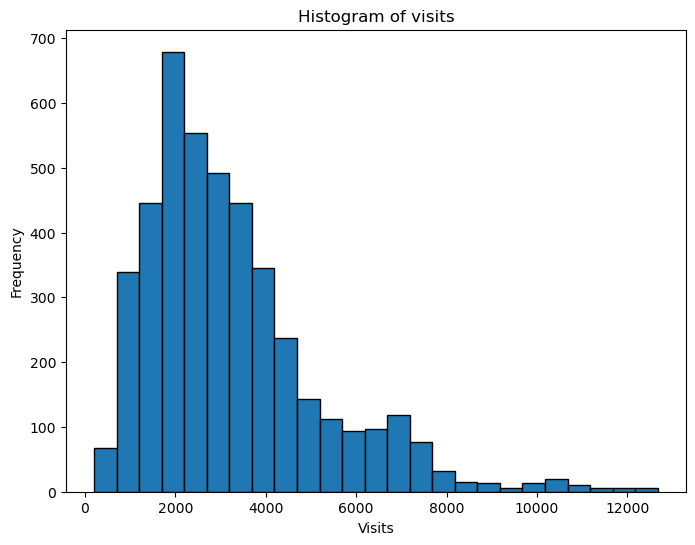

count     4370.000000
mean      3240.155835
std       1944.448232
min        201.000000
25%       1865.750000
50%       2800.500000
75%       4047.750000
max      12671.000000
Name: visits, dtype: float64


In [6]:
# Create the histogram
plt.figure(figsize=(8, 6)) # Optional: Adjust figure size
plt.hist(df_clean['visits'], bins=25, edgecolor='black') # You can adjust the number of bins
plt.title('Histogram of visits')
plt.xlabel('Visits')
plt.ylabel('Frequency')
plt.savefig('figures/visits_hist.png', dpi=300, bbox_inches='tight')
plt.show()
print(df_clean['visits'].describe())

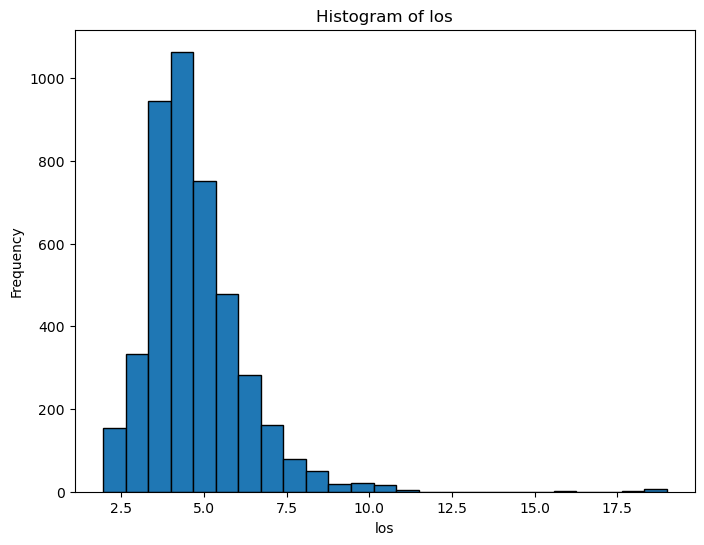

count    4370.000000
mean        4.728065
std         1.526947
min         1.946932
25%         3.797722
50%         4.437053
75%         5.387521
max        18.992425
Name: average_los_hours, dtype: float64


In [7]:
# Create the histogram
plt.figure(figsize=(8, 6)) # Optional: Adjust figure size
plt.hist(df_clean['average_los_hours'], bins=25, edgecolor='black') # You can adjust the number of bins
plt.title('Histogram of los')
plt.xlabel('los')
plt.ylabel('Frequency')
plt.savefig('figures/los_hist.png', dpi=300, bbox_inches='tight')
plt.show()
print(df_clean['average_los_hours'].describe())

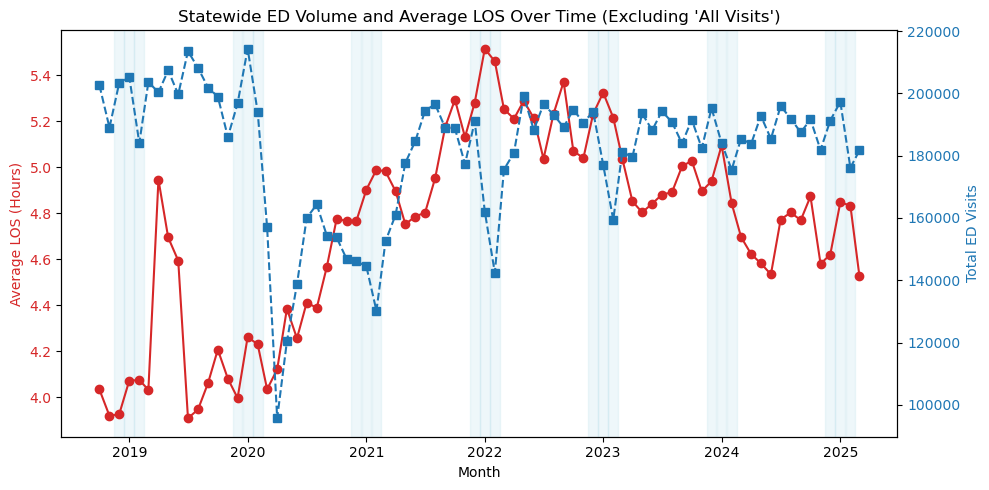

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D

# aggregate to statewide, by month
state_monthly = (
    df_clean.groupby("month", as_index=False)
        .agg(
            total_visits=("visits", "sum"),
            avg_los_hours=("average_los_hours", "mean")
        )
        .sort_values("month")
)

# ----------------------------------
# PLOT
# ----------------------------------

fig, ax1 = plt.subplots(figsize=(10, 5))

# -------------------------
# Highlight WINTER months (Dec, Jan, Feb)
# -------------------------
state_monthly["month"] = pd.to_datetime(state_monthly["month"])
for date in state_monthly["month"]:
    if date.month in [12, 1, 2]:
        ax1.axvspan(
            date - pd.Timedelta(days=15),
            date + pd.Timedelta(days=15),
            color="lightblue",
            alpha=0.2,
            zorder=0
        )

# -------------------------
# Line 1: Average LOS
# -------------------------
ax1.plot(
    state_monthly["month"],
    state_monthly["avg_los_hours"],
    marker="o",
    color="tab:red",
    label="Average LOS (Hours)"
)
ax1.set_xlabel("Month")
ax1.set_ylabel("Average LOS (Hours)", color="tab:red")
ax1.tick_params(axis="y", labelcolor="tab:red")

# -------------------------
# Line 2: Total Visits
# -------------------------
ax2 = ax1.twinx()
ax2.plot(
    state_monthly["month"],
    state_monthly["total_visits"],
    marker="s",
    linestyle="--",
    color="tab:blue",
    label="Total Visits"
)
ax2.set_ylabel("Total ED Visits", color="tab:blue")
ax2.tick_params(axis="y", labelcolor="tab:blue")

plt.title("Statewide ED Volume and Average LOS Over Time (Excluding 'All Visits')")
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig('figures/Statewide_ED_Volume_LOS_Winter_Shaded.png.png', dpi=300, bbox_inches='tight')
plt.show()


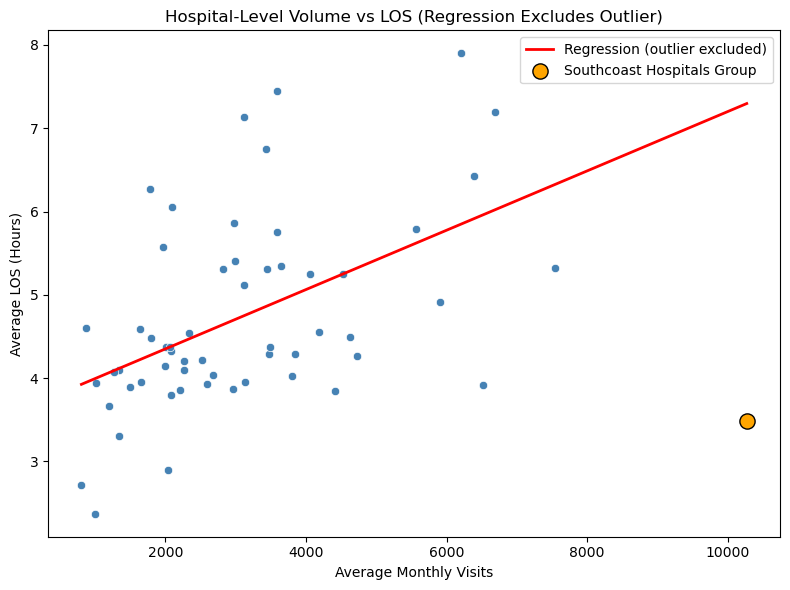

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# compute hospital-level averages
hospital_summary = (
    df_clean.groupby("emergency_department", as_index=False)
        .agg(
            avg_visits=("visits", "mean"),
            avg_los_hours=("average_los_hours", "mean")
        )
)

# identify the outlier hospital (Southcoast)
outlier_name = "Southcoast Hospitals Group"  # update if needed

# create regression data excluding outlier
reg_data = hospital_summary[
    hospital_summary["emergency_department"] != outlier_name
]

# compute regression line manually
x = reg_data["avg_visits"].values
y = reg_data["avg_los_hours"].values

# linear regression
slope, intercept = np.polyfit(x, y, 1)

# generate line for plotting
x_line = np.linspace(min(hospital_summary["avg_visits"]),
                     max(hospital_summary["avg_visits"]), 200)
y_line = slope * x_line + intercept

# ---- plot ----
plt.figure(figsize=(8, 6))

# scatter plot (all hospitals including outlier)
sns.scatterplot(
    data=hospital_summary,
    x="avg_visits",
    y="avg_los_hours",
    color="steelblue"
)

# regression line (ignores outlier)
plt.plot(
    x_line, y_line,
    color="red",
    linewidth=2,
    label="Regression (outlier excluded)"
)

# highlight outlier
out = hospital_summary[hospital_summary["emergency_department"] == outlier_name]
plt.scatter(out["avg_visits"], out["avg_los_hours"], color="orange", s=120,edgecolor = "black", label="Southcoast Hospitals Group")

plt.xlabel("Average Monthly Visits")
plt.ylabel("Average LOS (Hours)")
plt.title("Hospital-Level Volume vs LOS (Regression Excludes Outlier)")
plt.legend()
plt.tight_layout()
plt.savefig('figures/Hospital-Level Volume vs LOS (Regression Excludes Outlier).png', dpi=300, bbox_inches='tight')
plt.show()


In [11]:
hospital_summary

,emergency_department,avg_visits,avg_los_hours
0,Anna Jaques Hospital,1491.269231,3.896494
1,Athol Memorial Hospital,870.346154,4.603124
2,Baystate Franklin Medical Center,1640.102564,4.589701
3,Baystate Medical Center,6386.205128,6.424937
4,Baystate Noble Hospital,2074.487179,4.326782
5,Baystate Wing Hospital,2520.923077,4.215843
6,Berkshire Medical Center,3471.038462,4.295355
7,Beth Israel Deaconess Hospital - Milton,2213.128205,3.856295
8,Beth Israel Deaconess Hospital - Needham,1341.474359,4.097836
9,Beth Israel Deaconess Hospital - Plymouth,2267.615385,4.200919


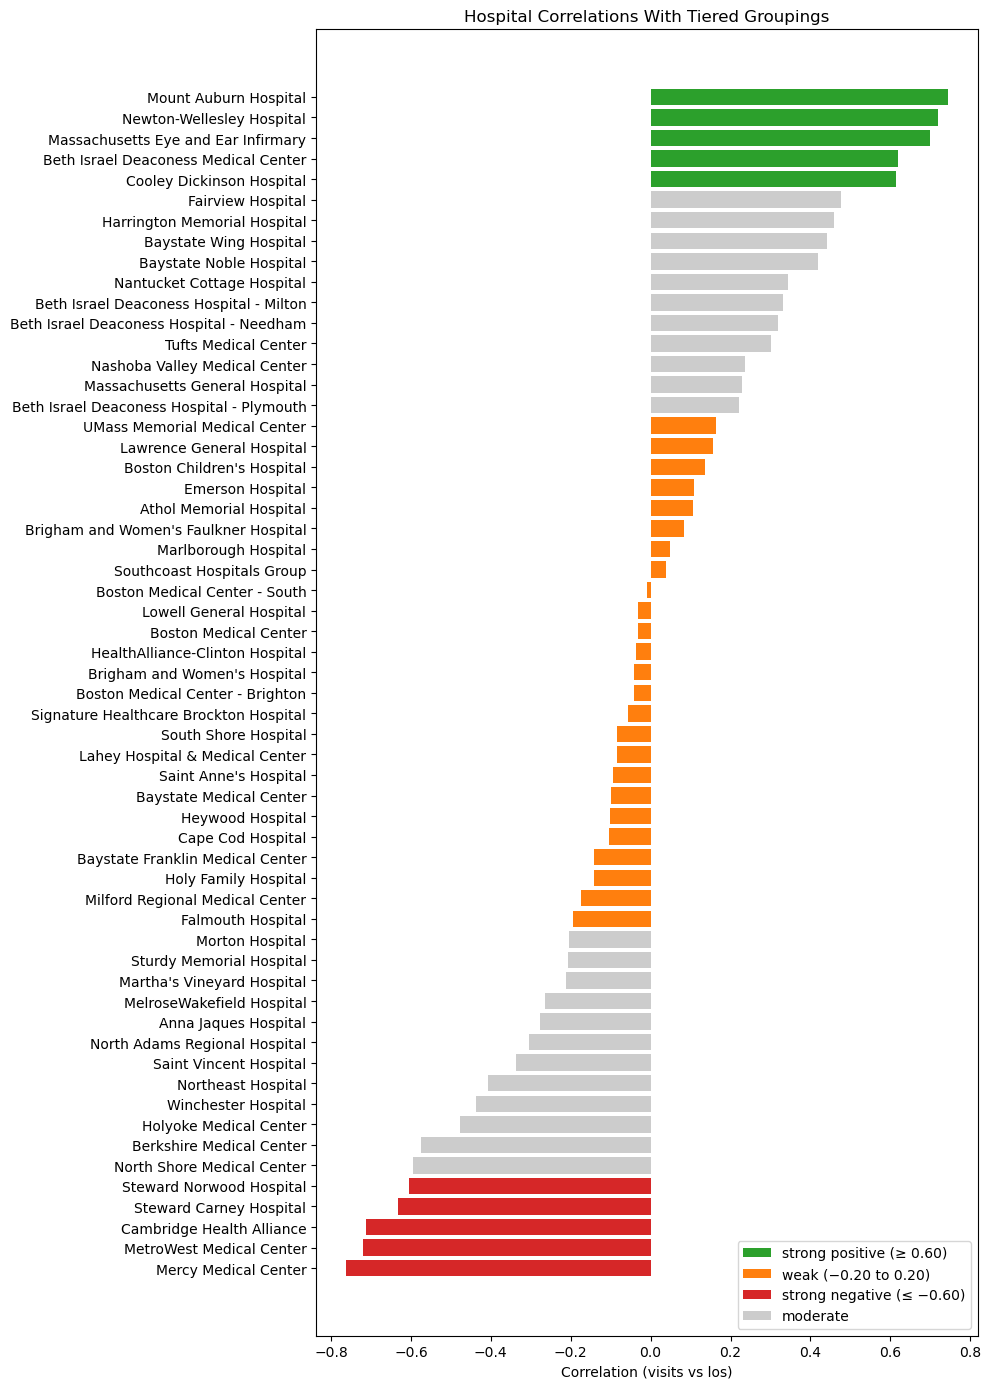

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# 1) bring correlation from df_clean into hospital_summary
#    (one correlation value per hospital)
corr_by_ed = (
    df_clean
    .groupby("emergency_department")["correlation"]
    .first()
)

hospital_summary["correlation"] = hospital_summary["emergency_department"].map(corr_by_ed)

# 2) define correlation tiers
strong_pos_thr = 0.60
weak_low_thr, weak_high_thr = -0.20, 0.20
strong_neg_thr = -0.60

conditions = [
    hospital_summary["correlation"] >= strong_pos_thr,
    (hospital_summary["correlation"] > weak_low_thr) & (hospital_summary["correlation"] < weak_high_thr),
    hospital_summary["correlation"] <= strong_neg_thr
]
choices = [
    "strong_positive",
    "weak",
    "strong_negative"
]

hospital_summary["corr_group"] = np.select(conditions, choices, default="moderate")

# 3) sort for plotting
hospital_summary_sorted = hospital_summary.sort_values("correlation", ascending=False).reset_index(drop=True)

color_map = {
    "strong_positive": "C2",
    "weak": "C1",
    "strong_negative": "C3",
    "moderate": "0.8",   # light gray
}
bar_colors = hospital_summary_sorted["corr_group"].map(color_map)

# 4) plot
plt.figure(figsize=(10, 14))
plt.barh(
    hospital_summary_sorted["emergency_department"],
    hospital_summary_sorted["correlation"],
    color=bar_colors
)
plt.gca().invert_yaxis()
plt.xlabel("Correlation (visits vs los)")
plt.title("Hospital Correlations With Tiered Groupings")

legend_items = [
    Patch(facecolor=color_map["strong_positive"], label="strong positive (≥ 0.60)"),
    Patch(facecolor=color_map["weak"], label="weak (−0.20 to 0.20)"),
    Patch(facecolor=color_map["strong_negative"], label="strong negative (≤ −0.60)"),
    Patch(facecolor=color_map["moderate"], label="moderate"),
]
plt.legend(handles=legend_items, loc="lower right")
plt.tight_layout()
plt.savefig('figures/Hospital Correlations With Tiered Groupings.png', dpi=300, bbox_inches='tight')
plt.show()


In [13]:
# efficiency score: hospitals that handle more volume at lower LOS score higher
hospital_summary['efficiency_score'] = (
    hospital_summary['avg_visits'] / hospital_summary['avg_los_hours']
)
hospital_summary = hospital_summary.sort_values(
    "efficiency_score",
    ascending=False
).reset_index(drop=True)

print(hospital_summary['emergency_department'].tail(7))


51    Beth Israel Deaconess Hospital - Needham
52                  Martha's Vineyard Hospital
53               North Adams Regional Hospital
54                  Nantucket Cottage Hospital
55                        Marlborough Hospital
56               Nashoba Valley Medical Center
57                     Athol Memorial Hospital
Name: emergency_department, dtype: object


In [14]:
# All weakly correlated hospitals (unsorted)
weak_hospitals = hospital_summary[hospital_summary["corr_group"] == "weak"]
print(weak_hospitals[["emergency_department"]])

                      emergency_department
0               Southcoast Hospitals Group
2                    Boston Medical Center
3                     South Shore Hospital
5                        Cape Cod Hospital
6                     Holy Family Hospital
7                  Baystate Medical Center
8                  Lowell General Hospital
9          Lahey Hospital & Medical Center
10           UMass Memorial Medical Center
12              Boston Children's Hospital
18               Lawrence General Hospital
21         Milford Regional Medical Center
25  Signature Healthcare Brockton Hospital
29                   Saint Anne's Hospital
31                        Emerson Hospital
35         HealthAlliance-Clinton Hospital
37                       Falmouth Hospital
38           Boston Medical Center - South
42            Brigham and Women's Hospital
44        Boston Medical Center - Brighton
46                        Heywood Hospital
48        Baystate Franklin Medical Center
49   Brigha

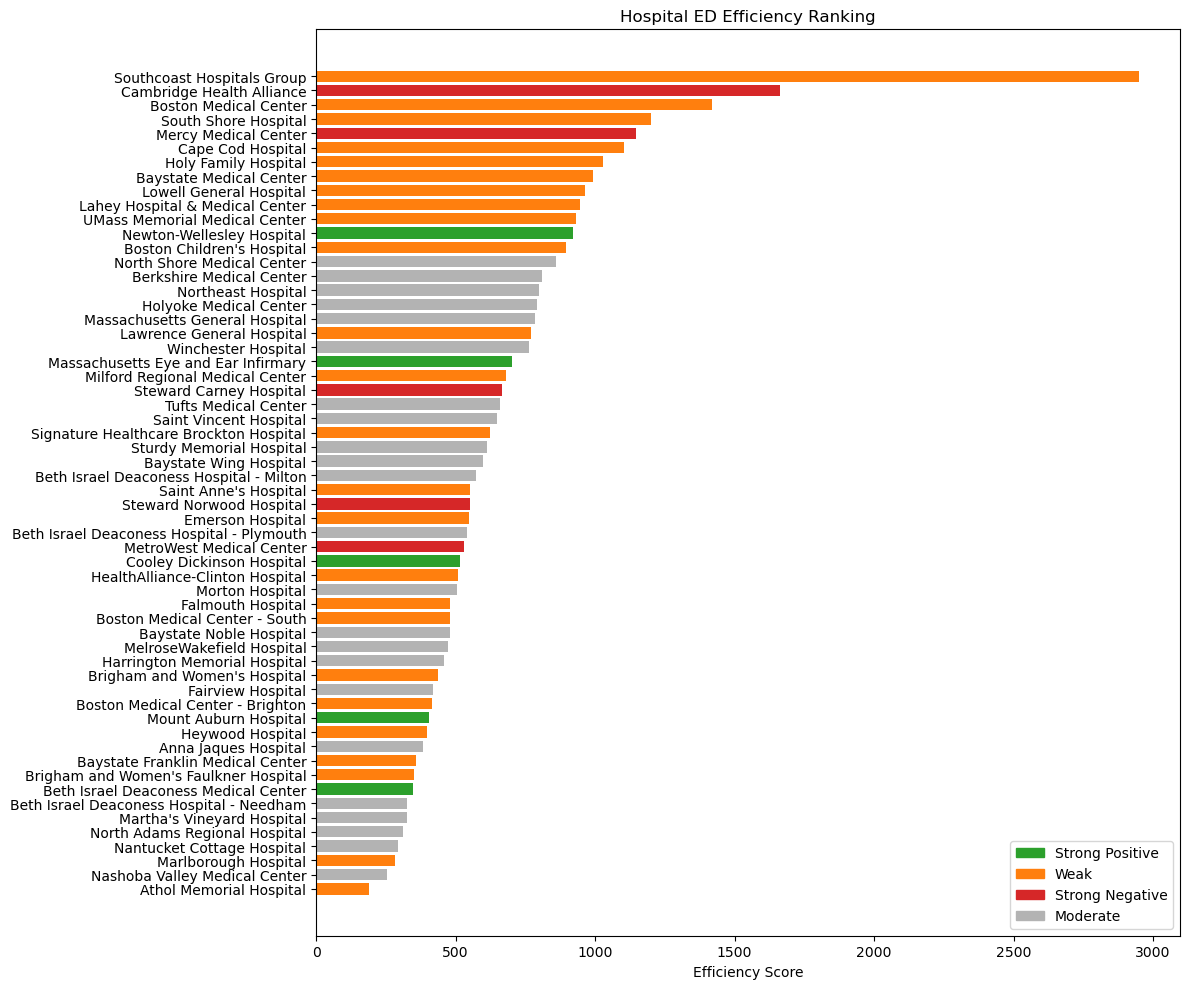

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# sort from best to worst efficiency
ranked = hospital_summary.sort_values("efficiency_score", ascending=False)

# simple color mapping for correlation groups
color_map = {
    "strong_positive": "C2",
    "weak": "C1",
    "strong_negative": "C3",
    "moderate": "0.7"   # light gray
}

bar_colors = ranked["corr_group"].map(color_map)

plt.figure(figsize=(12, 10))
plt.barh(
    ranked["emergency_department"],
    ranked["efficiency_score"],
    color=bar_colors
)
plt.gca().invert_yaxis()  # highest score at top

plt.xlabel("Efficiency Score")
plt.title("Hospital ED Efficiency Ranking")

# legend
legend_items = [
    Patch(color="C2", label="Strong Positive"),
    Patch(color="C1", label="Weak"),
    Patch(color="C3", label="Strong Negative"),
    Patch(color="0.7", label="Moderate")
]
plt.legend(handles=legend_items, loc="lower right")

plt.tight_layout()
plt.savefig('figures/Hospital ED Efficiency Ranking.png', dpi=300, bbox_inches='tight')
plt.show()


## System-Level Analysis

In [16]:
# efficiency score: more visits per hour of LOS = more efficient
df_clean["efficiency_score"] = df_clean["visits"] / df_clean["average_los_hours"]

In [17]:
system_summary = (
    df_clean.groupby("hospital_system", as_index=False)
            .agg(
                avg_visits=("visits", "mean"),
                avg_los_hours=("average_los_hours", "mean"),
                avg_correlation=("correlation", "mean"),
                avg_efficiency=("efficiency_score", "mean"),
                hospital_count=("emergency_department", "nunique")
            )
)

system_summary = system_summary.sort_values(
    "avg_efficiency", ascending=False
).reset_index(drop=True)

system_summary

,hospital_system,avg_visits,avg_los_hours,avg_correlation,avg_efficiency,hospital_count
0,Southcoast Health,10272.282051,3.483576,0.039010,3007.841504,1
1,CHA,6515.448718,3.915964,-0.711985,1732.560911,1
2,BMC Health System,7540.935897,5.320215,-0.032419,1436.037606,1
3,Trinity Health,4415.589744,3.848227,-0.762083,1345.302763,1
4,South Shore Health,5902.487179,4.918165,-0.083492,1207.484684,1
5,Boston Children’s,3843.000000,4.290508,0.135770,901.098721,1
6,Valley Health Systems (Independent),3132.230769,3.959552,-0.476726,855.121407,1
7,Cape Cod Healthcare,3357.955128,4.209706,-0.149318,801.467880,2
8,Tufts Medicine,3408.880342,4.698104,0.002083,719.967304,3
9,Steward Health Care,3260.846626,4.915038,-0.282135,703.939220,5


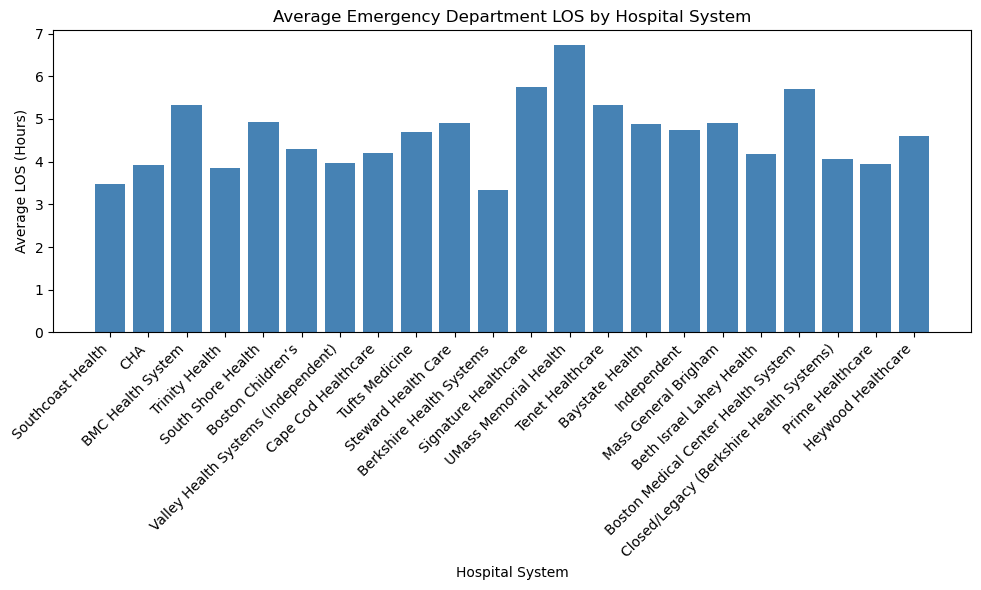

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.bar(
    system_summary["hospital_system"],
    system_summary["avg_los_hours"],
    color="steelblue"
)

plt.xticks(rotation=45, ha="right")
plt.ylabel("Average LOS (Hours)")
plt.xlabel("Hospital System")
plt.title("Average Emergency Department LOS by Hospital System")
plt.tight_layout()
plt.show()


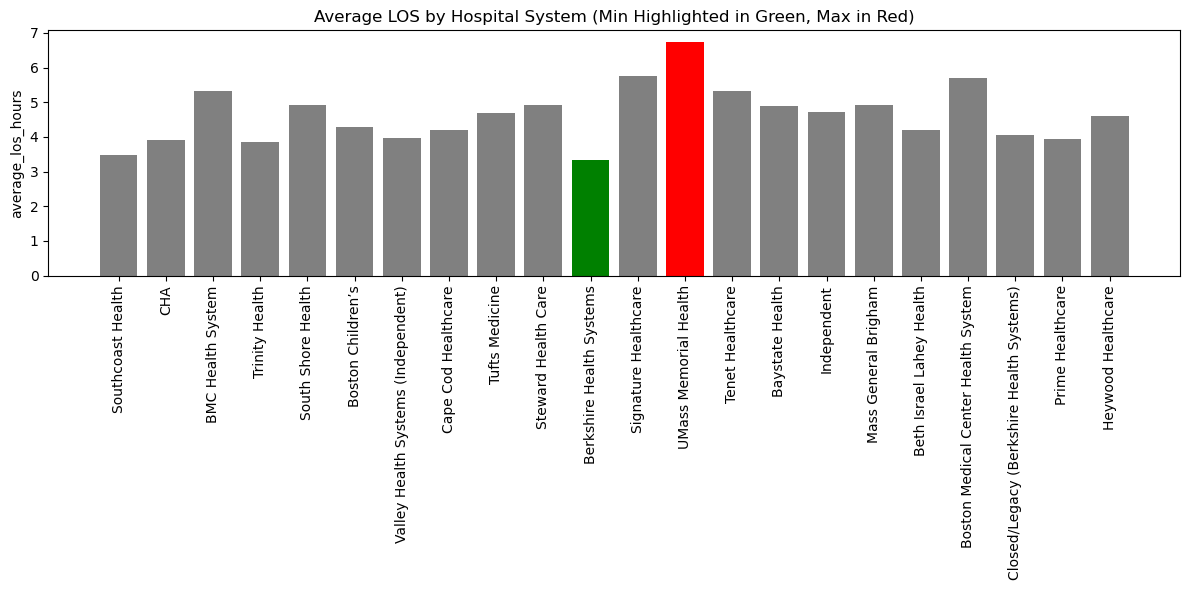

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# identify min and max LOS
min_los = system_summary["avg_los_hours"].min()
max_los = system_summary["avg_los_hours"].max()

min_system = system_summary.loc[system_summary["avg_los_hours"] == min_los, "hospital_system"].iloc[0]
max_system = system_summary.loc[system_summary["avg_los_hours"] == max_los, "hospital_system"].iloc[0]

colors = []
for sys, los in zip(system_summary["hospital_system"], system_summary["avg_los_hours"]):
    if sys == min_system:
        colors.append("green")       # best performer
    elif sys == max_system:
        colors.append("red")         # worst performer
    else:
        colors.append("gray")        # everyone else

plt.figure(figsize=(12, 6))
plt.bar(system_summary["hospital_system"], 
        system_summary["avg_los_hours"], 
        color=colors)

plt.xticks(rotation=90)
plt.ylabel("average_los_hours")
plt.title("Average LOS by Hospital System (Min Highlighted in Green, Max in Red)")
plt.tight_layout()
plt.savefig('figures/Average LOS by Hospital System (Min Highlighted in Green, Max in Red).png', dpi=300, bbox_inches='tight')
plt.show()


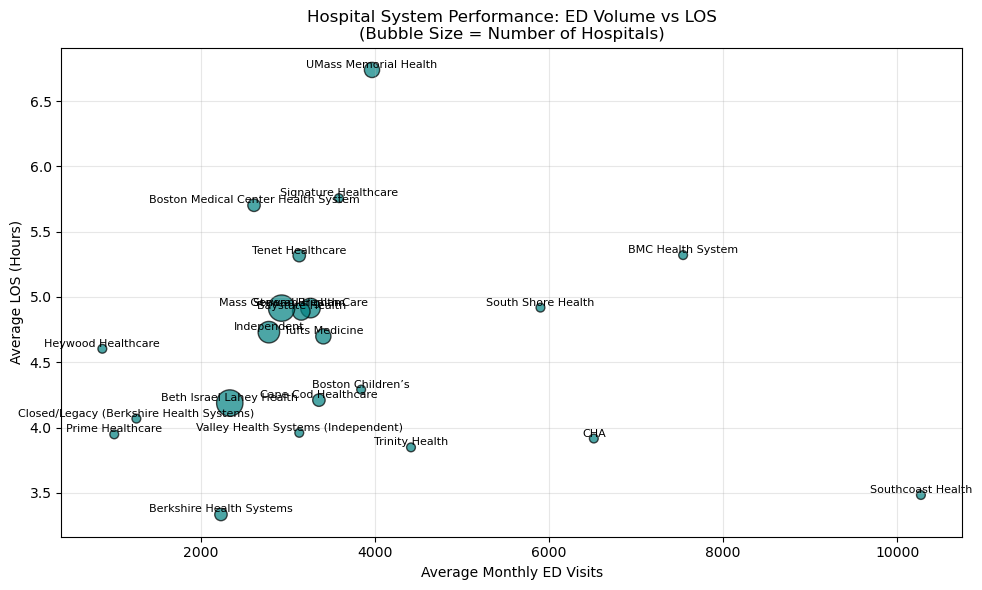

In [20]:
plt.figure(figsize=(10, 6))

plt.scatter(
    system_summary["avg_visits"],
    system_summary["avg_los_hours"],
    s=system_summary["hospital_count"] * 40,  # scale bubble size
    alpha=0.7,
    color="teal",
    edgecolor="black"
)

for i, row in system_summary.iterrows():
    plt.text(
        row["avg_visits"],
        row["avg_los_hours"],
        row["hospital_system"],
        fontsize=8,
        ha="center",
        va="bottom"
    )

plt.xlabel("Average Monthly ED Visits")
plt.ylabel("Average LOS (Hours)")
plt.title("Hospital System Performance: ED Volume vs LOS\n(Bubble Size = Number of Hospitals)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
